In [3]:
import os, gc, zipfile
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

PATH = 'D:/FYP/dataset/clean/'
IMAGES = os.listdir(PATH)
print('There are',len(IMAGES))
print(IMAGES[:5])

There are 20264 images. Here are 5 example filesnames:
['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg']


In [5]:
from PIL import Image
import os

def resize_images(input_folder, output_folder, target_size):
   
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Get a list of all files in the input folder
    files = os.listdir(input_folder)
    
    # Loop through each file
    for file in files:
        # Check if the file is an image
        if file.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            # Open the image
            with Image.open(os.path.join(input_folder, file)) as img:
                # Resize the image
                resized_img = img.resize(target_size, Image.ANTIALIAS)
                # Save the resized image to the output folder
                resized_img.save(os.path.join(output_folder, file))

input_folder = 'D:/FYP/dataset/clean'
output_folder = 'D:/FYP/dataset/resized_clean'
target_size = (256, 256)  # Specify the target size for resizing

resize_images(input_folder, output_folder, target_size)

input_folder = 'D:/FYP/dataset/degraded'
output_folder = 'D:/FYP/dataset/resized_degraded'

resize_images(input_folder, output_folder, target_size)

C:\Users\ujesh\AppData\Local\Temp\ipykernel_26068\3789670772.py:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize(target_size, Image.ANTIALIAS)


# Build Autoencoder
This code is inspired by Keras' tutorial [here][1]

[1]: https://blog.keras.io/building-autoencoders-in-keras.html

In [16]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

BATCH_SIZE = 256; EPOCHS = 10
train_datagen = ImageDataGenerator(rescale=1./255)
train_batches = train_datagen.flow_from_directory('D:/FYP/dataset/resized_dataset/',
        target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)

Found 20264 images belonging to 1 classes.


In [17]:
# ENCODER
input_img = Input(shape=(64, 64, 3))  
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# LATENT SPACE
latentSize = (8,8,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))

autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

# Train Autoencoder

In [18]:
history = autoencoder.fit_generator(train_batches,
        steps_per_epoch = train_batches.samples // BATCH_SIZE,
        epochs = EPOCHS, verbose=2)


C:\Users\ujesh\AppData\Local\Temp\ipykernel_26068\2009359955.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(train_batches,


Epoch 1/10
79/79 - 390s - loss: 0.5835 - 390s/epoch - 5s/step
Epoch 2/10
79/79 - 310s - loss: 0.5470 - 310s/epoch - 4s/step
Epoch 3/10
79/79 - 314s - loss: 0.5439 - 314s/epoch - 4s/step
Epoch 4/10
79/79 - 318s - loss: 0.5426 - 318s/epoch - 4s/step
Epoch 5/10
79/79 - 325s - loss: 0.5406 - 325s/epoch - 4s/step
Epoch 6/10
79/79 - 312s - loss: 0.5395 - 312s/epoch - 4s/step
Epoch 7/10
79/79 - 317s - loss: 0.5390 - 317s/epoch - 4s/step
Epoch 8/10
79/79 - 476s - loss: 0.5380 - 476s/epoch - 6s/step
Epoch 9/10
79/79 - 429s - loss: 0.5367 - 429s/epoch - 5s/step
Epoch 10/10
79/79 - 421s - loss: 0.5362 - 421s/epoch - 5s/step


In [1]:
autoencoder.save('latentSpaceModel.h5')

NameError: name 'autoencoder' is not defined

# View Reconstruction
Our encoder works by mapping images from 12288 dimensional space (64 x 64 x 3) into 2048 dimensional space (latent image). This is a 6x compression rate. Our decoder works by mapping our latent image back into 12288 dimensional space. Below are examples. (Note that a decoder is like a GAN generator).

1/1 [==============================] - 0s 13ms/step


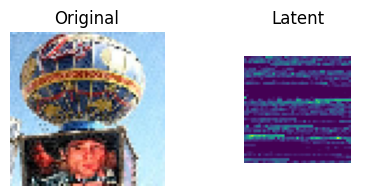

1/1 [==============================] - 0s 23ms/step


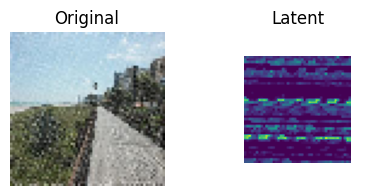

1/1 [==============================] - 0s 10ms/step


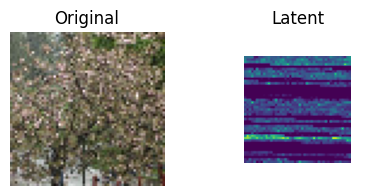

1/1 [==============================] - 0s 19ms/step


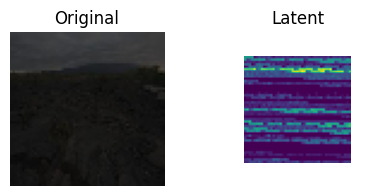

1/1 [==============================] - 0s 19ms/step


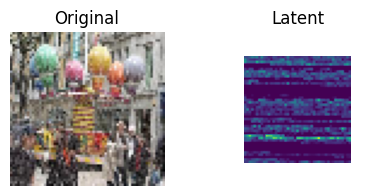

In [43]:
images = next(iter(train_batches))[0]
for i in range(5):

    # plt.show()
    fig, axs = plt.subplots(1, 2, figsize=(5, 2))

    # Plot the original image
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img_orig = Image.fromarray((255 * orig).astype('uint8').reshape((64,64,3)))
    axs[0].imshow(img_orig)
    axs[0].set_title('Original')
    axs[0].axis('off')

    # Plot the latent image
    latent_img = encoder.predict(orig)
    mx = np.max(latent_img[0])
    mn = np.min(latent_img[0])
    latent_flat = ((latent_img[0] - mn) * 255 / (mx - mn)).flatten(order='F')
    img_latent = Image.fromarray(latent_flat[:2025].astype('uint8').reshape((45,45)), mode='L')
    axs[1].imshow(img_latent)
    axs[1].set_title('Latent')
    axs[1].set_xlim((-10, 55))
    axs[1].set_ylim((-10, 55))
    axs[1].axis('off')

    plt.show()

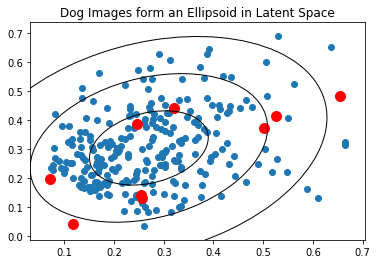

In [ ]:
from matplotlib.patches import Ellipse

# PROJECT LATENT INTO 2D, AVOID DEAD RELU
latent_img = encoder.predict(images)
latent_img2 = latent_img.reshape((-1,latentSize[0]*latentSize[1]*latentSize[2]))
d = 0; s = 0
while s<0.1:
    x = latent_img2[:,d]
    s = np.std(x); d += 1
s = 0
while s<0.1:
    y = latent_img2[:,d]
    s = np.std(y); d += 1

# CALCULATE ELLIPSOID FROM 256 IMAGES
cov = np.cov(x, y)
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)
for j in [1,2,3]:
    ell = Ellipse(xy=(np.mean(x), np.mean(y)), width=lambda_[0]*j*2, 
            height=lambda_[1]*j*2, angle=np.rad2deg(np.arccos(v[0, 0])))
    ell.set_facecolor('None')
    ell.set_edgecolor('black')
    plt.gca().add_artist(ell)
    
# PLOT 256 IMAGES AS DOTS IN LATENT SPACE
plt.scatter(x,y)
d = np.random.multivariate_normal([np.mean(x),np.mean(y)],cov,9)
plt.scatter(d[:,0],d[:,1],color='red',s=100)
plt.title('Dog Images form an Ellipsoid in Latent Space')
plt.show()